In [438]:
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from category_encoders import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt

import datetime

In [439]:

# 데이터 불러오기
df = pd.read_csv('C:/Users/hm981/OneDrive/바탕 화면/AI부트캠프/project/teamproject2/feature_target.csv')  # 데이터셋 파일 경로 지정

# 데이터 탐색 및 전처리
df.drop(columns = ['customer_id', 'first_join_date'], inplace =True)

df.loc[:,'low'] = df.loc[:,'low'].astype('float32')
df.loc[:,'high'] = df.loc[:,'high'].astype('float32')
df.loc[:,'book_cnt'] = df.loc[:,'book_cnt'].astype('Int32')
df.loc[:,'time/event'] = df.loc[:,'time/event'].astype('float32')
df.loc[:,'add_book_mean'] = df.loc[:,'add_book_mean'].astype('float32')
df['revisit'] = pd.to_timedelta(df['revisit']).dt.total_seconds()
df.loc[:,'session_cnt'] = df.loc[:,'session_cnt'].astype('Int32')
df.loc[:,'add_last_event_ratio'] = df.loc[:,'add_last_event_ratio'].astype('float32')
df.loc[:,'promo_use_ratio'] = df.loc[:,'promo_use_ratio'].astype('float32')
df.loc[:,'average_revenue'] = df.loc[:,'average_revenue'].astype('float64')


In [440]:
df = df[(df['RFM_Segment'] == 122) | (df['RFM_Segment'] == 222) | (df['RFM_Segment'] == 322)] 

In [441]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23249 entries, 0 to 50698
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   gender                23249 non-null  object 
 1   home_location         23249 non-null  object 
 2   age_segment           23249 non-null  object 
 3   RFM_Segment           23249 non-null  float64
 4   low                   23249 non-null  float64
 5   high                  23249 non-null  float64
 6   book_cnt              23249 non-null  int64  
 7   time/event            23249 non-null  float64
 8   add_book_mean         23249 non-null  float64
 9   revisit               23249 non-null  float64
 10  session_cnt           23249 non-null  int64  
 11  add_last_event_ratio  23249 non-null  float64
 12  promo_use_ratio       23249 non-null  float64
 13  average_revenue       23249 non-null  float64
 14  bounce                23249 non-null  int64  
dtypes: float64(9), int64(3),

In [442]:
df_num = df.dtypes[(df.dtypes != "object") & (df.dtypes != "category")].index
df[df_num]


,RFM_Segment,low,high,book_cnt,time/event,add_book_mean,revisit,session_cnt,add_last_event_ratio,promo_use_ratio,average_revenue,bounce
0,322.0,0.135593,0.067797,89,104.576805,1.440230e+05,6.157089e+04,989,0.059656,0.202247,5.378502e+05,1
6,322.0,0.077670,0.097087,68,155.194504,4.192387e+05,1.495432e+05,930,0.068817,0.470588,4.678827e+05,1
8,322.0,0.153846,0.153846,9,189.035751,7.299083e+05,3.638545e+05,98,0.204082,0.666667,5.333492e+05,1
9,222.0,0.153846,0.115385,10,266.398499,1.901228e+06,2.371521e+06,61,0.229508,0.500000,1.256852e+06,1
11,222.0,0.230769,0.230769,8,221.053146,7.109158e+05,1.464772e+06,46,0.217391,0.000000,1.100497e+06,1
...,...,...,...,...,...,...,...,...,...,...,...,...
50690,122.0,0.222222,0.222222,7,409.366669,1.714790e+06,2.096400e+06,72,0.208333,0.571429,4.716734e+05,1
50695,322.0,0.133333,0.200000,37,141.346207,3.203798e+05,9.602015e+04,584,0.034247,0.324324,4.298294e+05,1
50696,322.0,0.075472,0.075472,44,223.700867,5.135048e+05,3.813352e+05,381,0.225722,0.295455,7.026864e+05,1
50697,322.0,0.089172,0.133758,96,124.382912,2.481931e+05,9.673476e+04,1273,0.061273,0.375000,5.901311e+05,1


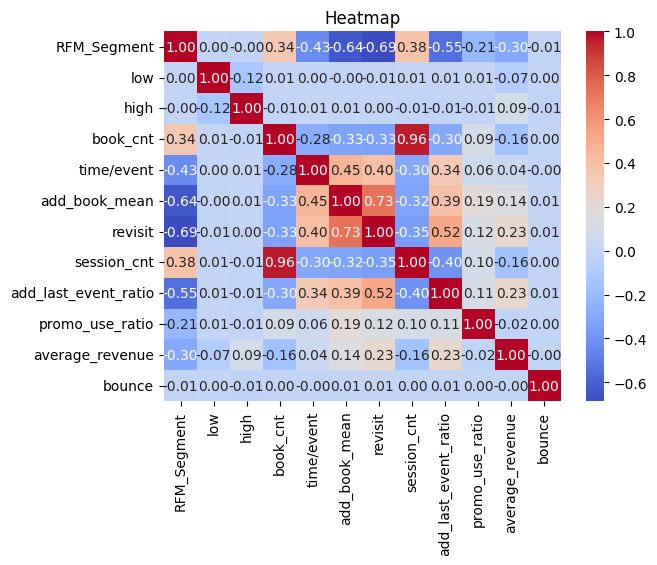

In [443]:
sns.heatmap(df[df_num].corr(), cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Heatmap")
plt.show()


In [444]:
# baseline 정확도 0.82548
df['bounce'].value_counts(normalize =True)

bounce
1    0.822358
0    0.177642
Name: proportion, dtype: float64

In [445]:

# 특성과 목표 변수 분리
X = df.drop(columns=['bounce'], axis=1)
y = df['bounce']

# 데이터 분할: 훈련 세트와 평가 세트
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 특성 스케일링: 표준화
numeric_feats = X_train.dtypes[(X_train.dtypes != "object") & (X_train.dtypes != "category")].index

scaler = StandardScaler()
X_train[numeric_feats] = scaler.fit_transform(X_train[numeric_feats])
X_test[numeric_feats] = scaler.transform(X_test[numeric_feats])

# One-Hot encoding
ohe = OneHotEncoder()

X_train_ohe = ohe.fit_transform(X_train)
X_test_ohe = ohe.transform(X_test)

# 로지스틱 회귀 모델 생성
logreg = LogisticRegression(
    class_weight= {1: len(df[df['bounce'] == 0]) / len(df[df['bounce'] == 1])},
    multi_class='ovr',
    C =  0.01,
    max_iter = 1000
    )
logreg.fit(X_train_ohe, y_train)

y_proba = logreg.predict_proba(X_test_ohe)[:, 1]

# 임계값 설정
threshold = 0.46

# 임계값을 적용하여 예측 값을 결정
y_pred = (y_proba > threshold).astype(int)

classification_rep = classification_report(y_test, y_pred, zero_division=1)


In [446]:
print(classification_rep)

              precision    recall  f1-score   support

           0       0.20      0.02      0.04       826
           1       0.82      0.98      0.89      3824

    accuracy                           0.81      4650
   macro avg       0.51      0.50      0.47      4650
weighted avg       0.71      0.81      0.74      4650



In [447]:
train_proba = logreg.predict_proba(X_train_ohe)[:, 1]
train_pred = (train_proba > threshold).astype(int)
train_accuracy = accuracy_score(y_train, train_pred)
train_accuracy

0.8098822517339642

In [448]:
accuracy_score(y_test, y_pred)

0.8098924731182796

In [449]:
print("ROC_AUC_score", roc_auc_score(y_test, y_pred))

ROC_AUC_score 0.5014332190219539


In [467]:
feature_importance = logreg.coef_[0]

# 결과 출력
feature_set = pd.DataFrame()
ls1 = []
ls2 = []
for feature, importance in zip(X_train_ohe.columns, feature_importance):
    ls1.append(feature)
    ls2.append(importance)

In [469]:
feature_set['feature'] = ls1
feature_set['importance'] = ls2

In [475]:
feature_set['abs'] = [abs(x) for x in ls2]

In [477]:
feature_set.sort_values('abs')

,feature,importance,abs
36,age_segment_2,-0.000407,0.000407
7,home_location_6,0.001929,0.001929
10,home_location_9,0.002784,0.002784
29,home_location_28,-0.003736,0.003736
44,book_cnt,0.004233,0.004233
41,RFM_Segment,-0.004463,0.004463
49,add_last_event_ratio,0.005625,0.005625
26,home_location_25,0.006253,0.006253
1,gender_2,-0.006456,0.006456
19,home_location_18,0.006693,0.006693
